# Prepare DF

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

'/home/tjanicek/thesis/thoth-issue-predictor'

In [2]:
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import Pool, CatBoostClassifier
from datetime import datetime
from thoth_issue_predictor.evaluation.metrics import Metrics
from thoth_issue_predictor.evaluation.model_evaluation import ModelEvaluation
from thoth_issue_predictor.preprocessing.grid_search import (
    grid_search_scikit,
    grid_search_catboost,
)
from thoth_issue_predictor.preprocessing.preprocessing import Preprocessing
from thoth_issue_predictor.preprocessing.utils import prepare_df

In [3]:
inspections_df = prepare_df()
exit_codes = inspections_df["exit_code"]

In [4]:
preprocessing = Preprocessing(inspections_df)
issues_df, python_indexes = preprocessing.create_df()

In [5]:
issues_df["exit_code"] = exit_codes.astype("int")
issues_df = issues_df.loc[
    (issues_df.loc[:, issues_df.columns != "exit_code"] != 0).any(axis=1)
]
issues_df = issues_df.drop_duplicates()

In [6]:
python_indexes

['unknown', 'pypi-org-simple', 'pypi-org', 'aicoe', 'pypi']

In [7]:
print(f"Length of DF is {len(issues_df)}")
issues_df.head(5)

Length of DF is 1947


,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_micro,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_micro,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_micro,tensorflow-cpu_index,exit_code
0,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,38,2,4,0,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Failed inspections

In [8]:
failed_inspections = issues_df[issues_df["exit_code"] == 1]
print(f"Number of failed inspections: {len(failed_inspections)}")
failed_inspections.head()

Number of failed inspections: 102


,python,tensorflow_major,tensorflow_minor,tensorflow_micro,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_micro,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_micro,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_micro,tensorflow-cpu_index,exit_code
1896,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1897,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1898,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1899,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1900,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Decision Trees

In [9]:
issue_x, exit_codes = issues_df.drop("exit_code", axis=1), issues_df["exit_code"]

X_train, X_test, y_train, y_test = train_test_split(
    issue_x, exit_codes, test_size=0.4, random_state=0
)

## Scikit CART model

In [10]:
best_params = grid_search_scikit(X_train, y_train)
best_params

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'random_state': 20,
 'splitter': 'random'}

In [11]:
clf = DecisionTreeClassifier(**best_params)

start = datetime.now()
clf.fit(X_train, y_train)
end = datetime.now()

pred = clf.predict(X_test)

In [12]:
feature_names = issue_x.columns
target_names = ["successful", "failed"]
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictor", format="pdf")

'trees/ThothIssuePredictor.pdf'

Train time: 0:00:00.006842
Number of errors: 9
AUC: 0.9453395703395702
Accuracy Score: 0.9884467265725289
F1 weighted: 0.9885159427842972
F1 micro: 0.9884467265725289
F1 macro: 0.93999537833466
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       740
           1       0.88      0.90      0.89        39

    accuracy                           0.99       779
   macro avg       0.93      0.95      0.94       779
weighted avg       0.99      0.99      0.99       779

Confusion matrix for scikit
[[735   5]
 [  4  35]]


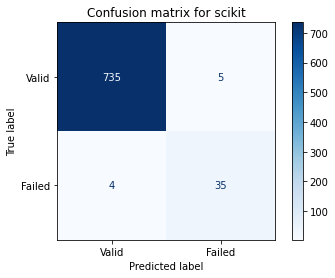

In [13]:
scikit_evaluation = ModelEvaluation("scikit", clf, end - start, X_test, y_test)
scikit_evaluation.predict_and_save()
scikit_evaluation.print()

## CatBoost GBDT model

In [14]:
cat_features = [f for f in feature_names if "_index" in f]

issue_pool = Pool(issue_x, exit_codes, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [15]:
best_params = grid_search_catboost(train_pool)


bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate

In [16]:
clf = CatBoostClassifier(use_best_model=True, **best_params)
best_params

{'depth': 6,
 'l2_leaf_reg': 3,
 'iterations': 1000,
 'verbose': False,
 'eval_metric': 'AUC',
 'loss_function': 'Logloss',
 'leaf_estimation_iterations': 10}

In [17]:
clf.tree_count_

In [18]:
start = datetime.now()
clf.fit(train_pool, eval_set=train_pool)
end = datetime.now()

pred = clf.predict(test_pool)

In [19]:
dot_data = clf.plot_tree(1, pool=test_pool)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictorBoost", format="pdf")

'trees/ThothIssuePredictorBoost.pdf'

Train time: 0:00:10.943010
Number of errors: 6
AUC: 0.9230769230769231
Accuracy Score: 0.9922978177150192
F1 weighted: 0.991992442946318
F1 micro: 0.9922978177150192
F1 macro: 0.9563144908030508
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       740
           1       1.00      0.85      0.92        39

    accuracy                           0.99       779
   macro avg       1.00      0.92      0.96       779
weighted avg       0.99      0.99      0.99       779

Confusion matrix for catboost
[[740   0]
 [  6  33]]


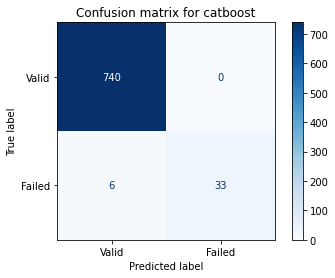

In [20]:
catboost_evaluation = ModelEvaluation("catboost", clf, end - start, X_test, y_test)
catboost_evaluation.predict_and_save()
catboost_evaluation.print()

## Comparison

--------------------------------------------
Results for each category from best to worst
--------------------------------------------
train_time:
1. scikit: 0:00:00.006842
2. catboost: 0:00:10.943010


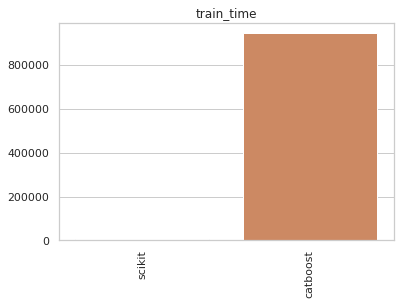

number_of_errors:
1. catboost: 6
2. scikit: 9


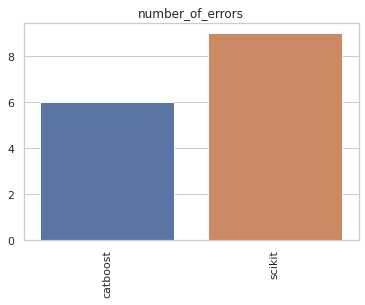

auc:
1. scikit: 0.9453395703395702
2. catboost: 0.9230769230769231


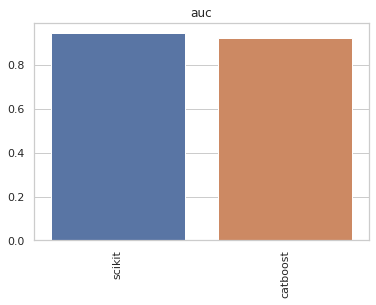

accuracy_score:
1. catboost: 0.9922978177150192
2. scikit: 0.9884467265725289


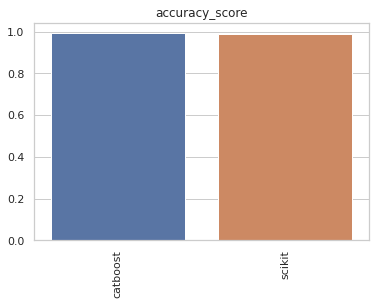

f1_weighted:
1. catboost: 0.991992442946318
2. scikit: 0.9885159427842972


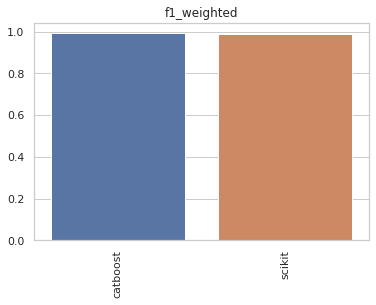

f1_micro:
1. catboost: 0.9922978177150192
2. scikit: 0.9884467265725289


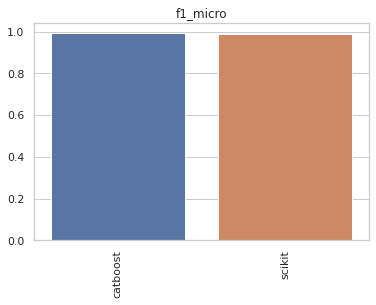

f1_macro:
1. catboost: 0.9563144908030508
2. scikit: 0.93999537833466


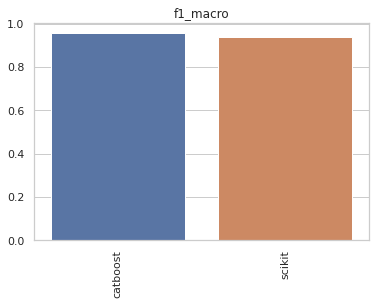

-----------------------------
Best models for each category
-----------------------------
train_time: scikit
number_of_errors: catboost
auc: scikit
accuracy_score: catboost
f1_weighted: catboost
f1_micro: catboost
f1_macro: catboost


In [21]:
metrics = Metrics([scikit_evaluation, catboost_evaluation])

metrics.sort_metrics()
print("--------------------------------------------")
print("Results for each category from best to worst")
print("--------------------------------------------")
metrics.print_results()

print("-----------------------------")
print("Best models for each category")
print("-----------------------------")
metrics.print_best()